# Homework 5 - Dario Placencio

### 1.2 Experiments (20 Points)

In [92]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy import stats
import matplotlib.pyplot as plt

# K-Means Clustering
def kmeans(X, k, max_iters=100, tol=1e-4, n_restarts=10):
    best_labels = None
    best_centroids = None
    best_objective = np.inf

    for _ in range(n_restarts):
        # Initialize centroids randomly
        centroids = X[np.random.choice(range(len(X)), k, replace=False)]
        prev_centroids = centroids.copy()

        for _ in range(max_iters):
            # Assign each point to the nearest centroid
            distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
            labels = np.argmin(distances, axis=0)

            # Calculate new centroids as the mean of all points assigned to each centroid
            for i in range(k):
                points_for_centroid = X[labels == i]
                if points_for_centroid.size:
                    centroids[i] = np.mean(points_for_centroid, axis=0)

            # Check for convergence
            if np.all(np.abs(centroids - prev_centroids) <= tol):
                break
            prev_centroids = centroids.copy()

        # Calculate the objective for this run
        current_objective = clustering_objective(centroids, X, labels)

        # If this run's objective is the best so far, remember its results
        if current_objective < best_objective:
            best_labels = labels
            best_centroids = centroids
            best_objective = current_objective

    return best_labels, best_centroids

def clustering_objective(centroids, X, labels):
    return np.sum((X - centroids[labels])**2)

# Gaussian Mixture Models
def gmm(X, k, max_iters=100, tol=1e-4, n_restarts=10):
    best_labels = None
    best_means = None
    best_covariances = None
    best_pi = None
    best_log_likelihood = -np.inf

    for _ in range(n_restarts):
        # Initialize parameters using k-means++
        _, means = kmeans(X, k)
        covariances = np.array([np.cov(X.T) for _ in range(k)])
        pi = np.ones(k) / k
        prev_log_likelihood = None

        for _ in range(max_iters):
            # E-step: compute responsibilities
            weighted_pdfs = np.array([pi[j] * multivariate_normal.pdf(X, mean=means[j], cov=covariances[j]) 
                                      for j in range(k)])
            responsibilities = weighted_pdfs / weighted_pdfs.sum(axis=0)

            # M-step: update parameters
            Nk = responsibilities.sum(axis=1)
            for j in range(k):
                means[j] = (responsibilities[j][:, np.newaxis] * X).sum(axis=0) / Nk[j]
                X_centered = X - means[j]
                covariances[j] = (responsibilities[j][:, np.newaxis] * X_centered).T @ X_centered / Nk[j]
                pi[j] = Nk[j] / len(X)

            # Compute log likelihood
            log_likelihood = np.sum(np.log(weighted_pdfs.sum(axis=0)))

            # Check for convergence
            if prev_log_likelihood is not None and np.abs(log_likelihood - prev_log_likelihood) <= tol:
                break
            prev_log_likelihood = log_likelihood

        # If this run's log likelihood is the best so far, remember its results
        if log_likelihood > best_log_likelihood:
            best_labels = np.argmax(responsibilities, axis=0)
            best_means = means
            best_covariances = covariances
            best_pi = pi
            best_log_likelihood = log_likelihood

    return best_labels, best_means, best_covariances, best_pi

# Clustering Evaluation
def clustering_accuracy(true_labels, predicted_labels):
    unique_true_labels = np.unique(true_labels)
    label_mapping = {}
    for true_label in unique_true_labels:
        mask = true_labels == true_label
        # Find the predicted label that is most common for each true label
        unique, counts = np.unique(predicted_labels[mask], return_counts=True)
        label_mapping[true_label] = unique[np.argmax(counts)]
    
    # Vectorized comparison of true labels with the predicted labels after mapping
    mapped_predicted_labels = np.vectorize(label_mapping.get)(true_labels)
    return np.mean(mapped_predicted_labels == predicted_labels)

Clustering objectives and accuracies for various sigma values:
Sigma: 0.5, K-means Objective: 301.11279684417957, K-means Accuracy: 0.8133333333333334
Sigma: 0.5, GMM Objective: 903.1197955262134, GMM Accuracy: 0.79
Sigma: 1, K-means Objective: 513.1548537578044, K-means Accuracy: 0.6933333333333334
Sigma: 1, GMM Objective: 1049.221413986048, GMM Accuracy: 0.6233333333333333
Sigma: 2, K-means Objective: 1010.429899865795, K-means Accuracy: 0.5966666666666667
Sigma: 2, GMM Objective: 1240.9855658819838, GMM Accuracy: 0.5766666666666667
Sigma: 4, K-means Objective: 1932.838266722306, K-means Accuracy: 0.5566666666666666
Sigma: 4, GMM Objective: 1429.3776925064926, GMM Accuracy: 0.51
Sigma: 8, K-means Objective: 3244.4062768056024, K-means Accuracy: 0.5366666666666666
Sigma: 8, GMM Objective: 1584.5929945304292, GMM Accuracy: 0.58


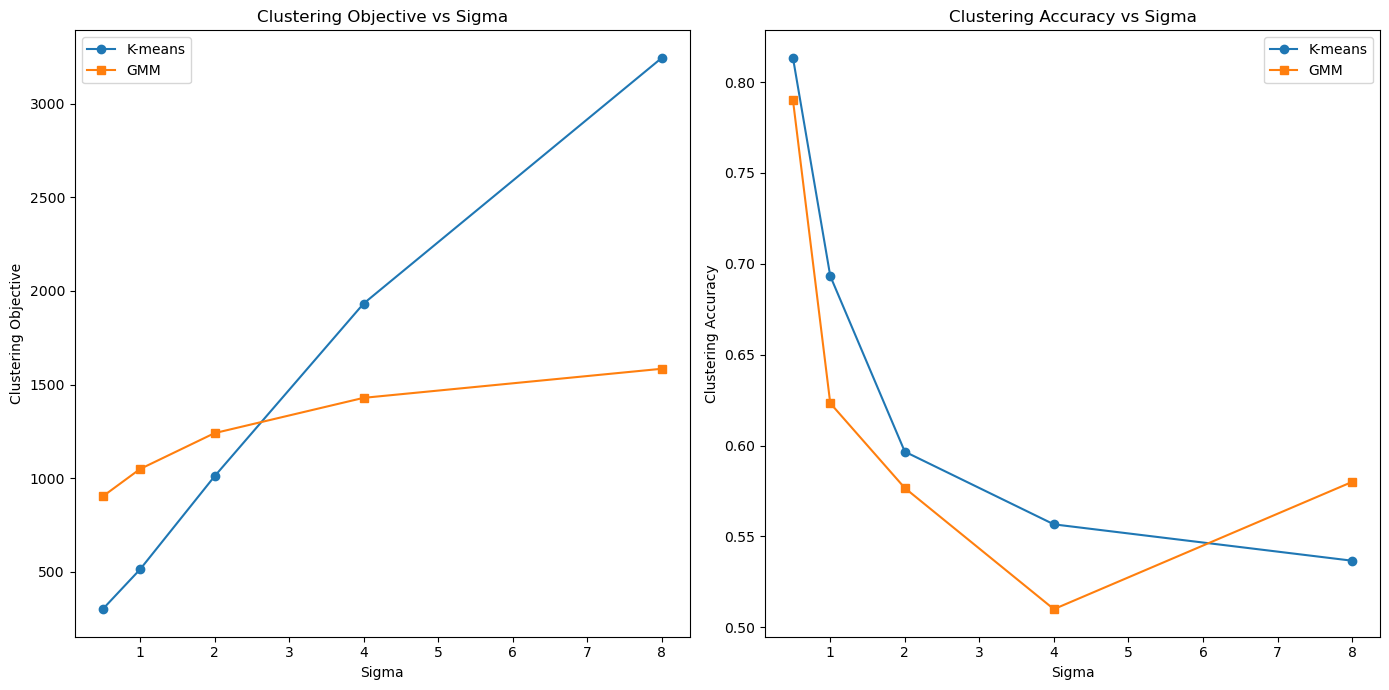

In [93]:
# Set random seed for reproducibility
np.random.seed(42)

# Define sigma values and points per distribution
sigma_values = [0.5, 1, 2, 4, 8]

# Define the mean and covariance of each Gaussian distribution for data generation
means = [np.array([-1, -1]), np.array([1, -1]), np.array([0, 1])]
covariances = [np.array([[2, 0.5], [0.5, 1]]), np.array([[1, -0.5], [-0.5, 2]]), np.array([[1, 0], [0, 2]])]

# Function to generate datasets with different sigma values
def generate_data(sigma, n_points=100):
    data = []
    labels = []
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        try:
            scaled_cov = sigma * cov
            points = np.random.multivariate_normal(mean, scaled_cov, n_points)
            data.append(points)
            labels += [i] * n_points
        except np.linalg.LinAlgError as e:
            print(f"Failed to generate data for sigma={sigma} due to {e}")
            return None, None
    return np.vstack(data), np.array(labels)

# To store the results
kmeans_objectives = []
kmeans_accuracies = [] 
gmm_objectives = []
gmm_accuracies = [] 

# Perform clustering with KMeans and GMM for each sigma value
print("Clustering objectives and accuracies for various sigma values:")
for sigma in sigma_values:
    X, true_labels = generate_data(sigma)

    # KMeans clustering with multiple restarts
    kmeans_labels, kmeans_centers = kmeans(X, 3, n_restarts=10)
    kmeans_objective = clustering_objective(kmeans_centers, X, kmeans_labels)
    kmeans_accuracy = clustering_accuracy(true_labels, kmeans_labels)  # Calculate accuracy
    kmeans_accuracies.append(kmeans_accuracy)  # Append the calculated accuracy

    # GMM clustering with multiple restarts
    gmm_labels, gmm_means, gmm_covariances, gmm_pi = gmm(X, 3, n_restarts=10)
    gmm_objective = -np.sum(np.log(np.sum([pi * multivariate_normal(mean=mean, cov=cov).pdf(X) for mean, cov, pi in zip(gmm_means, gmm_covariances, gmm_pi)], axis=0)))
    gmm_accuracy = clustering_accuracy(true_labels, gmm_labels)  # Calculate accuracy
    gmm_accuracies.append(gmm_accuracy)  # Append the calculated accuracy

    # Store the objectives
    kmeans_objectives.append(kmeans_objective)
    gmm_objectives.append(gmm_objective)

    # Print the objectives and accuracies for each sigma
    print(f"Sigma: {sigma}, K-means Objective: {kmeans_objective}, K-means Accuracy: {kmeans_accuracy}")
    print(f"Sigma: {sigma}, GMM Objective: {gmm_objective}, GMM Accuracy: {gmm_accuracy}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(sigma_values, kmeans_objectives, marker='o', label='K-means')
plt.plot(sigma_values, gmm_objectives, marker='s', label='GMM')
plt.xlabel('Sigma')
plt.ylabel('Clustering Objective')
plt.title('Clustering Objective vs Sigma')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma_values, kmeans_accuracies, marker='o', label='K-means')
plt.plot(sigma_values, gmm_accuracies, marker='s', label='GMM')
plt.xlabel('Sigma')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy vs Sigma')
plt.legend()

plt.tight_layout()

### 2.3 Experiments (34 Points)

In [94]:
import numpy as np

def buggy_pca(X, d):
    """
    Perform PCA without any preprocessing.
    Args:
    X: Data matrix (n x D)
    d: Target dimension
    
    Returns:
    Z: Lower-dimensional representation (n x d)
    V: Principal components (D x d)
    X_reconstructed: Reconstructed data (n x D)
    """
    # Compute SVD
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    # Take the first d principal components
    V = Vt.T[:, :d]
    # Project data
    Z = np.dot(X, V)
    # Reconstruct data
    X_reconstructed = np.dot(Z, V.T)
    return Z, V, X_reconstructed

def demeaned_pca(X, d):
    """
    Perform PCA with mean subtraction.
    Args:
    X: Data matrix (n x D)
    d: Target dimension
    
    Returns:
    Z: Lower-dimensional representation (n x d)
    V: Principal components (D x d)
    X_reconstructed: Reconstructed data (n x D)
    """
    # Subtract the mean
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    # Compute SVD
    U, s, Vt = np.linalg.svd(X_demeaned, full_matrices=False)
    # Take the first d principal components
    V = Vt.T[:, :d]
    # Project data
    Z = np.dot(X_demeaned, V)
    # Reconstruct data and reverse the mean subtraction
    X_reconstructed = np.dot(Z, V.T) + mean_X
    return Z, V, X_reconstructed

def normalized_pca(X, d):
    """
    Perform PCA with mean subtraction and standard deviation normalization.
    Args:
    X: Data matrix (n x D)
    d: Target dimension
    
    Returns:
    Z: Lower-dimensional representation (n x d)
    V: Principal components (D x d)
    X_reconstructed: Reconstructed data (n x D)
    """
    # Subtract the mean and divide by the std dev
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    X_normalized = (X - mean_X) / std_X
    # Compute SVD
    U, s, Vt = np.linalg.svd(X_normalized, full_matrices=False)
    # Take the first d principal components
    V = Vt.T[:, :d]
    # Project data
    Z = np.dot(X_normalized, V)
    # Reconstruct data and reverse the normalization
    X_reconstructed = (np.dot(Z, V.T) * std_X) + mean_X
    return Z, V, X_reconstructed

def robust_dro(X, d, epsilon=1e-6):
    # Compute median and MAD
    median = np.median(X, axis=0)
    mad = np.median(np.abs(X - median), axis=0) + epsilon  # Ensure non-zero MAD
    
    # Center and scale
    X_centered = X - median
    X_scaled = X_centered / mad
    
    # Compute the robust covariance matrix
    # Weights are computed using broadcasting, and each feature's weights are normalized to sum to 1
    weights = 1 / (np.abs(X_scaled) + epsilon)
    weights /= np.sum(weights, axis=0, keepdims=True)  # Normalize weights for each feature
    robust_cov = (X_scaled.T * weights.T) @ X_scaled
    
    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(robust_cov)
    # Select the top d components based on the eigenvalues
    idx = np.argsort(eigenvalues)[::-1][:d]
    selected_vectors = eigenvectors[:, idx]
    
    # Project data onto the selected components
    Z = X_scaled @ selected_vectors
    
    # Reconstruct data from the lower-dimensional representation
    X_reconstructed = (Z @ selected_vectors.T) * mad + median
    
    # Compute reconstruction error
    reconstruction_error = np.mean(np.square(X - X_reconstructed))
    
    return Z, selected_vectors, median, X_reconstructed, reconstruction_error


def reconstruction_error(X, X_reconstructed):
    # Calculate the mean squared error
    mse = np.mean((X - X_reconstructed) ** 2)
    
    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    
    # Normalize by variance
    variance = np.var(X, ddof=1)  # Using Bessel's correction with ddof=1
    normalized_error = mse / variance if variance > 0 else float('inf')  # Avoid division by zero
    
    return mse, rmse, normalized_error

In [95]:
import pandas as pd

# Load the 2D dataset
data2D = pd.read_csv("data2D.csv", header=None).values

# Apply each method to the 2D dataset with d=1
Z_buggy, V_buggy, X_rec_buggy = buggy_pca(data2D, d=1)
Z_demeaned, V_demeaned, X_rec_demeaned = demeaned_pca(data2D, d=1)
Z_normalized, V_normalized, X_rec_normalized = normalized_pca(data2D, d=1)
Z_dro, A_dro, median_dro, X_rec_dro, error_dro_precomputed = robust_dro(data2D, d=1)

# Calculate reconstruction errors for the 2D dataset
error_buggy_2D = reconstruction_error(data2D, X_rec_buggy)
error_demeaned_2D = reconstruction_error(data2D, X_rec_demeaned)
error_normalized_2D = reconstruction_error(data2D, X_rec_normalized)
error_dro_2D = reconstruction_error(data2D, X_rec_dro)

# Organize the errors into a DataFrame for better readability
errors_df = pd.DataFrame({
    'Buggy PCA': error_buggy_2D,
    'Demeaned PCA': error_demeaned_2D,
    'Normalized PCA': error_normalized_2D,
    'Robust DRO': error_dro_2D
}, index=['MSE', 'RMSE', 'Normalized Error'])

errors_df

,Buggy PCA,Demeaned PCA,Normalized PCA,Robust DRO
MSE,0.443452,0.005003,0.024736,0.021455
RMSE,0.665922,0.070732,0.157277,0.146474
Normalized Error,0.611876,0.006903,0.034131,0.029603


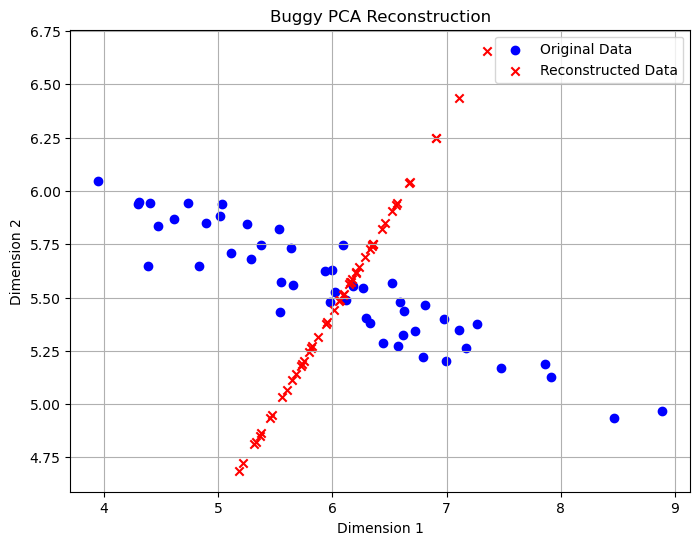

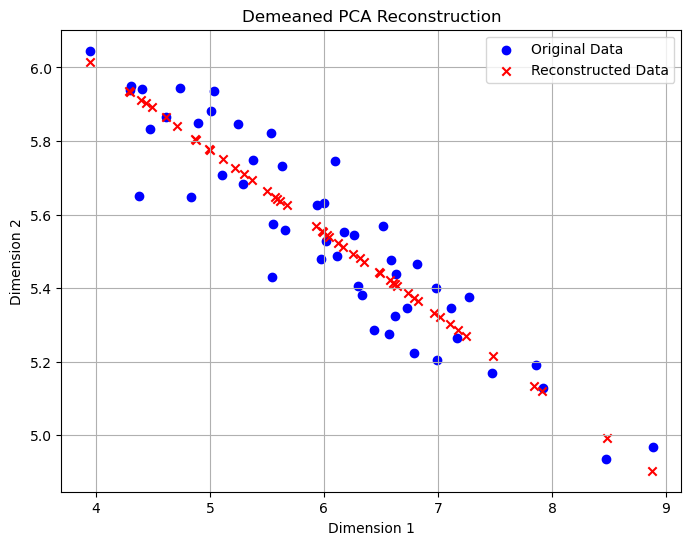

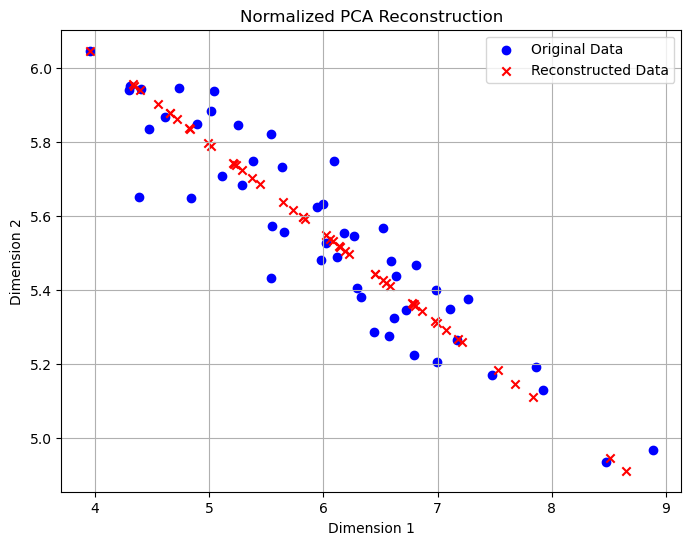

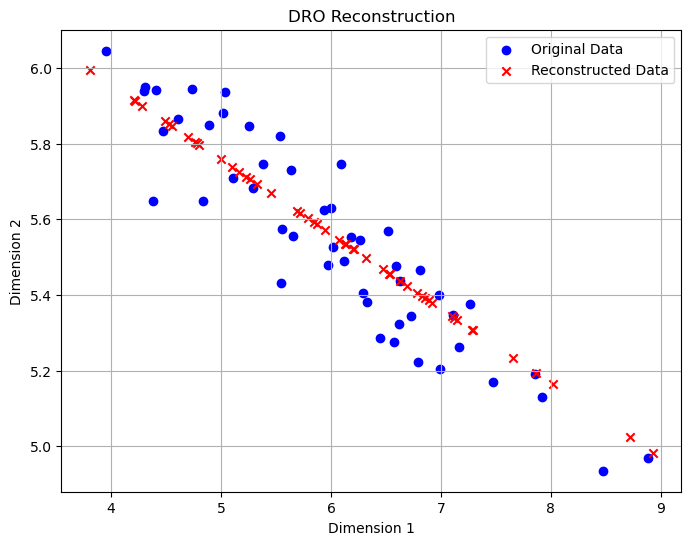

In [96]:
import matplotlib.pyplot as plt

# Function to plot original vs reconstructed points
def plot_reconstruction(original_data, reconstructed_data, method_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(original_data[:, 0], original_data[:, 1], c='blue', label='Original Data')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c='red', label='Reconstructed Data', marker='x')
    plt.title(f'{method_name} Reconstruction')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Buggy PCA
plot_reconstruction(data2D, X_rec_buggy, 'Buggy PCA')

# Plot for Demeaned PCA
plot_reconstruction(data2D, X_rec_demeaned, 'Demeaned PCA')

# Plot for Normalized PCA
plot_reconstruction(data2D, X_rec_normalized, 'Normalized PCA')

# Plot for DRO
plot_reconstruction(data2D, X_rec_dro, 'DRO')

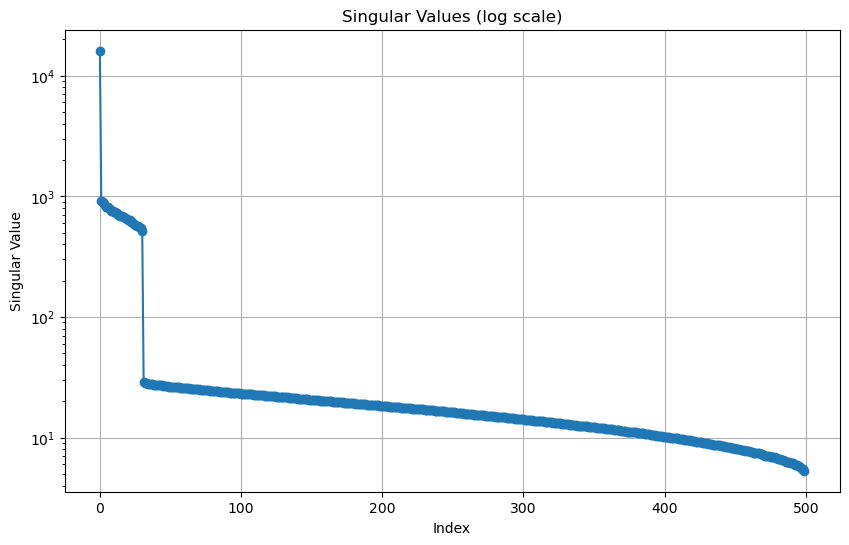

array([16045.54068641,   906.79511557,   899.23721784,   856.01200265,
         820.96944086,   819.63910179,   809.67102349,   777.9440578 ,
         754.20297724,   751.87289419])

In [97]:
# Load the 1000D dataset
data1000D = pd.read_csv("data1000D.csv", header=None).values  

# Perform SVD to observe the singular values
U, s, Vt = np.linalg.svd(data1000D, full_matrices=False)

# Plot the singular values
plt.figure(figsize=(10, 6))
plt.plot(s, marker='o')
plt.yscale('log')  # Use logarithmic scale to better visualize the knee point
plt.title('Singular Values (log scale)')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

# Return a few singular values for inspection
s[:10]  # Show the first 10 singular values

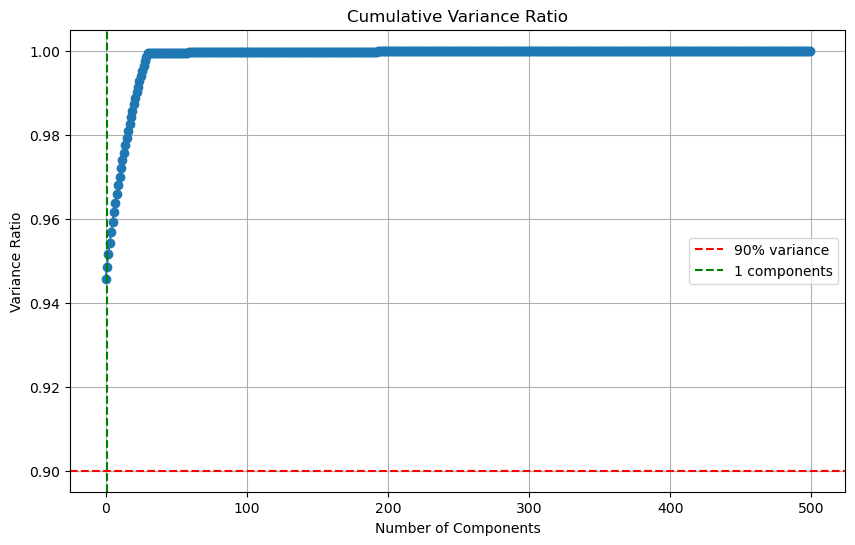

(1, array([0.94557254]))

In [98]:
# Calculate the cumulative variance explained by the singular values
cumulative_variance = np.cumsum(s**2)
total_variance = cumulative_variance[-1]
variance_ratio = cumulative_variance / total_variance

# Find the number of components needed to capture 90% of the variance
d_90_percent = np.argmax(variance_ratio >= 0.90) + 1  # +1 because index starts at 0

# Plot the cumulative variance ratio
plt.figure(figsize=(10, 6))
plt.plot(variance_ratio, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axvline(x=d_90_percent, color='g', linestyle='--', label=f'{d_90_percent} components')
plt.title('Cumulative Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()

d_90_percent, variance_ratio[:d_90_percent]  # Return the chosen d and variance ratios up to d

The analysis shows that just one component (dimension) captures approximately 94.56% of the total variance, which is more than the 90% threshold commonly used for deciding the number of dimensions. Therefore, for the data1000D dataset, we can reduce the dimensionality from 1000 to 1 without losing much information.

In [99]:
# Apply each method to the 1000D dataset with d=1
Z_buggy, V_buggy, X_rec_buggy = buggy_pca(data1000D, d=1)
Z_demeaned, V_demeaned, X_rec_demeaned = demeaned_pca(data1000D, d=1)
Z_normalized, V_normalized, X_rec_normalized = normalized_pca(data1000D, d=1)
Z_dro, A_dro, median_dro, X_rec_dro, error_dro_precomputed = robust_dro(data1000D, d=1)

# Calculate reconstruction errors for the data1000D dataset
error_buggy_1000D = reconstruction_error(data1000D, X_rec_buggy)
error_demeaned_1000D = reconstruction_error(data1000D, X_rec_demeaned)
error_normalized_1000D = reconstruction_error(data1000D, X_rec_normalized)
error_dro_1000D = reconstruction_error(data1000D, X_rec_dro)

# Organize the errors into a DataFrame for better readability
errors_df = pd.DataFrame({
    'Buggy PCA': error_buggy_1000D,
    'Demeaned PCA': error_demeaned_1000D,
    'Normalized PCA': error_normalized_1000D,
    'Robust DRO': error_dro_1000D
}, index=['MSE', 'RMSE', 'Normalized Error'])

errors_df

,Buggy PCA,Demeaned PCA,Normalized PCA,Robust DRO
MSE,29.638892,28.021361,28.039611,28.176330
RMSE,5.444161,5.293521,5.295244,5.308138
Normalized Error,0.260546,0.246327,0.246488,0.247689


1. Look at the results for Buggy PCA. The reconstruction error is bad and the reconstructed points don’t
seem to well represent the original points. Why is this? Hint: Which subspace is Buggy PCA trying to project the points onto?

For Buggy PCA, the reconstruction error is high and the reconstructed points don't accurately represent the original points because this implementation does not center the data by subtracting the mean before performing PCA. PCA is designed to project the data onto the subspace spanned by the eigenvectors (principal components) corresponding to the largest eigenvalues of the covariance matrix of the data.

Without centering, Buggy PCA is effectively finding the principal components of the raw data matrix, not the covariance matrix. This means it projects the points onto a subspace that does not account for the variation about the mean, but rather the variation from the origin, which is not the intended design of PCA. This often results in the first principal component being aligned with the mean of the data instead of the direction of maximum variance, leading to poor reconstruction when projecting back to the original space.

2. The error criterion we are using is the average squared error between the original points and the
reconstructed points. In both examples DRO and demeaned PCA achieves the lowest error among all
methods. Is this surprising? Why?

It is not surprising that Demeaned PCA achieves the lowest error among all methods for both examples, because demeaned PCA removes the mean, focusing on the variance, which is key for PCA, while Robust DRO is designed to be insensitive to outliers, preserving the structure of the majority of the data. Their effectiveness in reducing error reflects their ability to capture the essential structure of the dataset while reducing dimensionality.